In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/인프/final_project/kakao_train.csv ./kakao_train.csv

In [ ]:
!cp /content/drive/MyDrive/인프/final_project/kakao_valid.csv ./kakao_valid.csv

In [ ]:
!cp /content/drive/MyDrive/인프/final_project/kakao_test.csv ./kakao_test.csv

In [ ]:
!cp /content/drive/MyDrive/인프/final_project/kakao_dataset.csv ./kakao_dataset.csv

In [ ]:
!cp /content/drive/MyDrive/인프/final_project/wiki.ko.vec ./wiki.ko.vec

In [ ]:
!cp /content/drive/MyDrive/인프/final_project/img.zip ./img.zip

In [ ]:
!unzip img.zip -d img/

Archive:  img.zip
  inflating: img/10.png              
  inflating: img/100.png             
  inflating: img/1000.png            
  inflating: img/1001.png            
  inflating: img/1002.png            
  inflating: img/1003.png            
  inflating: img/1004.png            
  inflating: img/1005.png            
  inflating: img/1006.png            
  inflating: img/1007.png            
  inflating: img/1008.png            
  inflating: img/1009.png            
  inflating: img/101.png             
  inflating: img/1010.png            
  inflating: img/1011.png            
  inflating: img/1012.png            
  inflating: img/1013.png            
  inflating: img/1014.png            
  inflating: img/1015.png            
  inflating: img/1016.png            
  inflating: img/1017.png            
  inflating: img/1018.png            
  inflating: img/1019.png            
  inflating: img/102.png             
  inflating: img/1020.png            
  inflating: img/1021.png       

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import ast
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import time
import datetime

In [ ]:
df = pd.read_csv('kakao_dataset.csv', encoding='utf-8')
train = pd.read_csv('kakao_train.csv', encoding='utf-8')
val = pd.read_csv('kakao_valid.csv', encoding='utf-8')
test = pd.read_csv('kakao_test.csv', encoding='utf-8')

In [ ]:
# from sklearn.preprocessing import StandardScaler

# transformer = StandardScaler()
# data = pd.DataFrame(df['조회수'])
# transformer.fit(data)
# df['조회수'] = transformer.transform(data)

# FastText Transfer

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors

In [ ]:
MAX_SEQUENCE_LENGTH = df['소설제목_소개글'].map(len).max()
EMBEDDING_DIM = 300
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['소설제목_소개글'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print('Max len:', MAX_SEQUENCE_LENGTH)

Found 6100 unique tokens.
Max len: 88


In [ ]:
word_index.items()

dict_items([('하', 1), ('의', 2), ('이', 3), ('다', 4), ('ㄴ', 5), ('는', 6), ('가', 7), ('을', 8), ('어', 9), ('내', 10), ('되', 11), ('아', 12), ('었', 13), ('나', 14), ('은', 15), ('았', 16), ('를', 17), ('ㄹ', 18), ('에', 19), ('고', 20), ('지', 21), ('ㄴ다', 22), ('게', 23), ('주', 24), ('로', 25), ('님', 26), ('겠', 27), ('도', 28), ('ㅂ니다', 29), ('들', 30), ('어요', 31), ('너', 32), ('만', 33), ('시', 34), ('습니다', 35), ('기', 36), ('있', 37), ('그', 38), ('으로', 39), ('당신', 40), ('에서', 41), ('보', 42), ('회귀', 43), ('살', 44), ('없', 45), ('자', 46), ('않', 47), ('말', 48), ('면', 49), ('거', 50), ('싶', 51), ('결혼', 52), ('것', 53), ('수', 54), ('다시', 55), ('야', 56), ('천재', 57), ('과', 58), ('검', 59), ('버리', 60), ('네', 61), ('게임', 62), ('세계', 63), ('에게', 64), ('번', 65), ('안', 66), ('우리', 67), ('남자', 68), ('한', 69), ('남', 70), ('시작', 71), ('이제', 72), ('날', 73), ('는데', 74), ('무림', 75), ('헌터', 76), ('왜', 77), ('급', 78), ('돌아오', 79), ('신', 80), ('아니', 81), ('녀', 82), ('부터', 83), ('오', 84), ('라', 85), ('악', 86), ('라고', 87), ('와', 88), 

In [ ]:
def get_embedding_matrix():
  embedding_file = './wiki.ko.vec'
  embed_size = 300
  embeddings_index = dict()
  f = open(embedding_file)
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  f.close()
  print("Loaded "+str(len(embeddings_index))+" word vectors")
  embedding_matrix = 1*np.random.randn(len(word_index)+1, embed_size)
  embeddedCount=0
  for word, i in word_index.items():
    i-=1
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
      embeddedCount+=1
  print("total embedded:", embeddedCount, "common words")

  del(embeddings_index)

  return embedding_matrix

In [ ]:
fastText_embedding_matrix = get_embedding_matrix()

Loaded 879130 word vectors
total embedded: 5302 common words


# Preprocessing

In [ ]:
meanR = 0.5411
meanG = 0.4936
meanB = 0.4971
stdR = 0.2835
stdG = 0.2793
stdB = 0.2690

transform = transforms.Compose([transforms.Resize([224,224]), transforms.ToTensor(),
                                transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])])

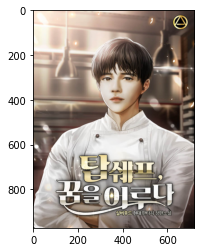

0


In [ ]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, df, transform=None):
      super(ImageDataset, self).__init__()
      self.df = df
      self.transform = transform
    
  def img_loader(self, path: str):
    with open("./"+ path, 'rb') as f:
      img = Image.open(f)
      return img.convert('RGB')

  def __len__(self):
      return len(self.df)

  def __getitem__(self, index: int):
    series = self.df.iloc[index]
    img_path = series['img_path']
    img = self.img_loader(img_path)
    target = series['label']
    if self.transform:
      img = self.transform(img)

    return img, target

img, target = ImageDataset(train)[0]
plt.imshow(img)
plt.show()
print(target)

In [ ]:
# from sklearn.model_selection import train_test_split

# train, test = train_test_split(df, test_size=0.2, random_state=42)
# val, test = train_test_split(test, test_size=0.5, random_state=42)

In [ ]:
train_labels = train['label'].values
val_labels = val['label'].values
test_labels = test['label'].values

In [ ]:
X_text_train = tokenizer.texts_to_sequences(train['소설제목_소개글'].values)
X_text_train = pad_sequences(X_text_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train tensor:', X_text_train.shape)

Shape of train tensor: (3815, 88)


In [ ]:
X_text_val = tokenizer.texts_to_sequences(val['소설제목_소개글'].values)
X_text_val = pad_sequences(X_text_val, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of valid tensor:', X_text_val.shape)

Shape of valid tensor: (477, 88)


In [ ]:
X_text_test = tokenizer.texts_to_sequences(test['소설제목_소개글'].values)
X_text_test = pad_sequences(X_text_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test tensor:', X_text_test.shape)

Shape of test tensor: (479, 88)


In [ ]:
text_train_data = TensorDataset(torch.from_numpy(X_text_train), torch.from_numpy(train_labels))
text_val_data = TensorDataset(torch.from_numpy(X_text_val), torch.from_numpy(val_labels))
text_test_data = TensorDataset(torch.from_numpy(X_text_test), torch.from_numpy(test_labels))

In [ ]:
img_train_data = ImageDataset(df=train, transform=transform)
img_val_data = ImageDataset(df=val, transform=transform)
img_test_data = ImageDataset(df=test, transform=transform)

In [ ]:
batch_size = 64

text_train_loader = DataLoader(text_train_data, batch_size=batch_size)
img_train_loader = DataLoader(img_train_data, batch_size=batch_size)

text_val_loader = DataLoader(text_val_data, batch_size=batch_size)
img_val_loader = DataLoader(img_val_data, batch_size=batch_size)

text_test_loader = DataLoader(text_test_data, batch_size=batch_size)
img_test_loader = DataLoader(img_test_data, batch_size=batch_size)

print(len(text_train_loader), len(img_train_loader))
print(len(text_val_loader), len(img_val_loader))
print(len(text_test_loader), len(img_test_loader))

60 60
8 8
8 8


# Model

In [ ]:
class CNN_LSTM(nn.Module):
  def __init__(self, vocab_size, weights_matrix, n_hidden, n_layers, n_out):
    super(CNN_LSTM, self).__init__()

    # LSTM for the text overview
    self.vocab_size, self.n_hidden, self.n_out, self.n_layers = vocab_size, n_hidden, n_out, n_layers
    num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
    self.emb = nn.Embedding(num_embeddings, embedding_dim)
    self.emb.weight.data.copy_(torch.from_numpy(weights_matrix))
    self.emb.weight.requires_grad = True
    self.lstm = nn.LSTM(embedding_dim, self.n_hidden, self.n_layers, bidirectional=False, dropout=0.5, batch_first=True)
    self.dropout = nn.Dropout(0.5)
    self.lstm_fc = nn.Linear(self.n_hidden, 256)
    # self.sigmoid = nn.Sigmoid()

    # CNN for the posters
    # self.conv1 = nn.Conv2d(3, 32, 3)
    # self.max_pool1 = nn.MaxPool2d(2)
    # self.conv2 = nn.Conv2d(32, 64, 3)
    # self.max_pool2 = nn.MaxPool2d(2)
    # self.conv3 = nn.Conv2d(64, 128, 3)
    # self.max_pool3 = nn.MaxPool2d(2)
    # self.conv4 = nn.Conv2d(128, 128, 3)
    # self.max_pool4 = nn.MaxPool2d(2)
    # self.cnn_dropout = nn.Dropout(0.5)
    # self.cnn_fc = nn.Linear(12*12*128, 512) #(10*10*128, 512)
    
    # ResNet18
    self.resnet = torchvision.models.resnet50(pretrained=True) #수정 resnet-18로 pretraining 과제하기
    self.resnet.fc = torch.nn.Linear(in_features=2048, out_features=256)


    # Concat layer for the combined feature space
    #self.combined_fc1 = nn.Linear(1024, 512)
    self.combined_fc2 = nn.Linear(512, 256)
    self.combined_fc3 = nn.Linear(256, 128)
    self.bn_fc1 = nn.BatchNorm1d(512, affine=False)
    self.bn_fc2 = nn.BatchNorm1d(256, affine=False)
    self.bn_fc3 = nn.BatchNorm1d(128, affine=False)
    self.bn_out = nn.BatchNorm1d(3, affine=False)
    self.fc_dropout = nn.Dropout(0.5)
    self.output_fc = nn.Linear(128, n_out)


  def forward(self, lstm_inp, cnn_inp):
    batch_size = lstm_inp.size(0)
    hidden = self.init_hidden(batch_size)
    lstm_inp = lstm_inp.long()
    embeds = self.emb(lstm_inp)
    lstm_out, hidden = self.lstm(embeds, hidden)
    lstm_out = self.dropout(lstm_out[:, -1])
    lstm_out = F.relu(self.lstm_fc(lstm_out))

    # x = F.relu(self.conv1(cnn_inp))
    # x = self.max_pool1(x)
    # x = F.relu(self.conv2(x))
    # x = self.max_pool2(x)
    # x = F.relu(self.conv3(x))
    # x = self.max_pool3(x)
    # x = F.relu(self.conv4(x))
    # x = self.max_pool4(x)
    # x = x.view(-1, 12*12*128)
    # x = self.cnn_dropout(x)
    # cnn_out = F.relu(self.cnn_fc(x))
    x = F.relu(self.resnet(cnn_inp))

    combined_inp = torch.cat((x, lstm_out), 1)
    x_comb = self.fc_dropout(F.relu(combined_inp))
    #x_comb = F.relu(self.bn_fc1(self.combined_fc1(combined_inp)))
    #x_comb = self.fc_dropout(x_comb)
    x_comb = F.relu(self.bn_fc2(self.combined_fc2(x_comb)))
    x_comb = self.fc_dropout(x_comb)
    x_comb = F.relu(self.bn_fc3(self.combined_fc3(x_comb)))
    x_comb = self.fc_dropout(x_comb)
    out = F.relu(self.bn_out(self.output_fc(x_comb)))

    return out

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
    return hidden

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
torch.cuda.empty_cache()

In [ ]:
save_path = "logs/my_board/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir=save_path)
vocab_size = len(word_index)+1
output_size = 3 #train_labels.shape[1]
embedding_dim = 300
hidden_dim = 512
n_layers = 2
print(output_size)

model = CNN_LSTM(vocab_size, fastText_embedding_matrix, hidden_dim, n_layers, output_size)
model.to(device)
print(model)

lr=0.0001
# criterion = nn.MultiLabelSoftMarginLoss()
criterion = nn.CrossEntropyLoss() #nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.9)

3
CNN_LSTM(
  (emb): Embedding(6101, 300)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm_fc): Linear(in_features=512, out_features=256, bias=True)
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size

In [ ]:
epochs = 100
#clip = 5
max = 0

model.train()
for i in tqdm(range(epochs)):
  total_acc_train = 0
  total_loss_train = 0
    
  for lstm, cnn in zip(text_train_loader, img_train_loader):
    lstm_inp, lstm_labels = lstm
    cnn_inp, cnn_labels = cnn
    lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)
    cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
    model.zero_grad()
    output = model(lstm_inp, cnn_inp)
    loss = criterion(output.squeeze(), lstm_labels)
    loss.backward()
    #nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    
    with torch.no_grad():
      # acc = torch.abs(output.squeeze() - lstm_labels.long()).view(-1)
      # acc = (1. - acc.sum() / acc.size()[0])
      _, predicted = torch.max(output.data, 1)
      batch_total = lstm_labels.size(0)
      batch_correct = (predicted == lstm_labels).sum().item()
      acc = batch_correct / batch_total
      total_acc_train += acc
      total_loss_train += loss.item()
  
  train_acc = total_acc_train/len(text_train_loader)
  train_loss = total_loss_train/len(text_train_loader)
  model.eval()
  total_acc_val = 0
  total_loss_val = 0
  with torch.no_grad():
    for lstm, cnn in zip(text_val_loader, img_val_loader):
      lstm_inp, lstm_labels = lstm
      cnn_inp, cnn_labels = cnn
      lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)
      cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
      model.zero_grad()
      output = model(lstm_inp, cnn_inp)
      val_loss = criterion(output.squeeze(), lstm_labels)
      #acc = evaluation(dev_loader)
      _, predicted = torch.max(output.data, 1)
      batch_total = lstm_labels.size(0)
      batch_correct = (predicted == lstm_labels).sum().item()
      acc = batch_correct / batch_total
      total_acc_val += acc
      total_loss_val += val_loss.item()

  val_acc = total_acc_val/len(text_val_loader)
  val_loss = total_loss_val/len(text_val_loader)
  if max < val_acc :
      max = val_acc
      print("   !!!!!!! max val acc: ", max)
      torch.save(model.state_dict(), 'model-best.ckpt')
  print(f'Epoch {i+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
  writer.add_scalar(tag='loss', scalar_value=train_loss, global_step=i)
  writer.add_scalars(main_tag='acc', tag_scalar_dict={'train': train_acc, 'dev':val_acc}, global_step=i)
  model.train()
  torch.cuda.empty_cache()

  0%|          | 0/100 [00:00<?, ?it/s]

   !!!!!!! max val acc:  0.34051724137931033


  1%|          | 1/100 [01:38<2:42:29, 98.48s/it]

Epoch 1: train_loss: 1.2141 train_acc: 0.3325 | val_loss: 1.1011 val_acc: 0.3405


  2%|▏         | 2/100 [03:16<2:40:41, 98.38s/it]

Epoch 2: train_loss: 1.2095 train_acc: 0.3410 | val_loss: 1.1026 val_acc: 0.3372


  3%|▎         | 3/100 [04:54<2:38:36, 98.11s/it]

Epoch 3: train_loss: 1.1827 train_acc: 0.3419 | val_loss: 1.1019 val_acc: 0.3167
   !!!!!!! max val acc:  0.361328125


  4%|▍         | 4/100 [06:33<2:37:12, 98.25s/it]

Epoch 4: train_loss: 1.1247 train_acc: 0.3216 | val_loss: 1.0972 val_acc: 0.3613


  5%|▌         | 5/100 [08:10<2:35:20, 98.11s/it]

Epoch 5: train_loss: 1.1205 train_acc: 0.3000 | val_loss: 1.0953 val_acc: 0.3613


  6%|▌         | 6/100 [09:48<2:33:41, 98.10s/it]

Epoch 6: train_loss: 1.1104 train_acc: 0.3220 | val_loss: 1.1017 val_acc: 0.3351


  7%|▋         | 7/100 [11:26<2:31:54, 98.01s/it]

Epoch 7: train_loss: 1.1109 train_acc: 0.3231 | val_loss: 1.0966 val_acc: 0.3457


  8%|▊         | 8/100 [13:04<2:30:20, 98.05s/it]

Epoch 8: train_loss: 1.1088 train_acc: 0.3104 | val_loss: 1.0966 val_acc: 0.3535


  9%|▉         | 9/100 [14:42<2:28:42, 98.05s/it]

Epoch 9: train_loss: 1.1030 train_acc: 0.3383 | val_loss: 1.0954 val_acc: 0.3496
   !!!!!!! max val acc:  0.375


 10%|█         | 10/100 [16:21<2:27:10, 98.12s/it]

Epoch 10: train_loss: 1.1062 train_acc: 0.3184 | val_loss: 1.0963 val_acc: 0.3750


 11%|█         | 11/100 [17:59<2:25:26, 98.05s/it]

Epoch 11: train_loss: 1.1017 train_acc: 0.3292 | val_loss: 1.0951 val_acc: 0.3453


 12%|█▏        | 12/100 [19:37<2:23:47, 98.05s/it]

Epoch 12: train_loss: 1.1043 train_acc: 0.3306 | val_loss: 1.0989 val_acc: 0.3339


 13%|█▎        | 13/100 [21:14<2:22:02, 97.96s/it]

Epoch 13: train_loss: 1.1035 train_acc: 0.3162 | val_loss: 1.0981 val_acc: 0.3594


 14%|█▍        | 14/100 [22:52<2:20:24, 97.95s/it]

Epoch 14: train_loss: 1.1044 train_acc: 0.3236 | val_loss: 1.0966 val_acc: 0.3730


 15%|█▌        | 15/100 [24:30<2:18:48, 97.99s/it]

Epoch 15: train_loss: 1.1022 train_acc: 0.3261 | val_loss: 1.0961 val_acc: 0.3594


 16%|█▌        | 16/100 [26:08<2:17:01, 97.87s/it]

Epoch 16: train_loss: 1.1008 train_acc: 0.3051 | val_loss: 1.0968 val_acc: 0.3281


 17%|█▋        | 17/100 [27:46<2:15:22, 97.86s/it]

Epoch 17: train_loss: 1.0983 train_acc: 0.3434 | val_loss: 1.0979 val_acc: 0.3579


 18%|█▊        | 18/100 [29:24<2:13:41, 97.83s/it]

Epoch 18: train_loss: 1.0995 train_acc: 0.3339 | val_loss: 1.0987 val_acc: 0.3636


 19%|█▉        | 19/100 [31:02<2:12:07, 97.88s/it]

Epoch 19: train_loss: 1.1023 train_acc: 0.3274 | val_loss: 1.0986 val_acc: 0.3477


 20%|██        | 20/100 [32:39<2:10:25, 97.81s/it]

Epoch 20: train_loss: 1.1012 train_acc: 0.3346 | val_loss: 1.0991 val_acc: 0.2852


 21%|██        | 21/100 [34:17<2:08:49, 97.85s/it]

Epoch 21: train_loss: 1.0973 train_acc: 0.3597 | val_loss: 1.0991 val_acc: 0.3633


 22%|██▏       | 22/100 [35:55<2:07:08, 97.80s/it]

Epoch 22: train_loss: 1.1004 train_acc: 0.3200 | val_loss: 1.0983 val_acc: 0.3182


 23%|██▎       | 23/100 [37:33<2:05:28, 97.77s/it]

Epoch 23: train_loss: 1.0984 train_acc: 0.3542 | val_loss: 1.0972 val_acc: 0.3499


 24%|██▍       | 24/100 [39:11<2:03:55, 97.83s/it]

Epoch 24: train_loss: 1.1002 train_acc: 0.3254 | val_loss: 1.1115 val_acc: 0.2806
   !!!!!!! max val acc:  0.3875942887931034


 25%|██▌       | 25/100 [40:49<2:02:22, 97.89s/it]

Epoch 25: train_loss: 1.0687 train_acc: 0.3193 | val_loss: 1.0861 val_acc: 0.3876


 26%|██▌       | 26/100 [42:27<2:00:44, 97.89s/it]

Epoch 26: train_loss: 1.1181 train_acc: 0.3107 | val_loss: 1.0962 val_acc: 0.3809


 27%|██▋       | 27/100 [44:04<1:59:05, 97.89s/it]

Epoch 27: train_loss: 1.1006 train_acc: 0.3003 | val_loss: 1.0970 val_acc: 0.3789


 28%|██▊       | 28/100 [45:42<1:57:30, 97.92s/it]

Epoch 28: train_loss: 1.0836 train_acc: 0.3247 | val_loss: 1.1233 val_acc: 0.3503


 29%|██▉       | 29/100 [47:20<1:55:46, 97.84s/it]

Epoch 29: train_loss: 1.1100 train_acc: 0.3732 | val_loss: 1.0975 val_acc: 0.3711


 30%|███       | 30/100 [48:58<1:54:08, 97.83s/it]

Epoch 30: train_loss: 1.0999 train_acc: 0.3139 | val_loss: 1.1015 val_acc: 0.3408


 31%|███       | 31/100 [50:36<1:52:26, 97.77s/it]

Epoch 31: train_loss: 1.0903 train_acc: 0.3567 | val_loss: 1.1052 val_acc: 0.3148


 32%|███▏      | 32/100 [52:13<1:50:45, 97.73s/it]

Epoch 32: train_loss: 1.1066 train_acc: 0.2850 | val_loss: 1.0963 val_acc: 0.3596


 33%|███▎      | 33/100 [53:51<1:49:10, 97.77s/it]

Epoch 33: train_loss: 1.0992 train_acc: 0.3016 | val_loss: 1.0954 val_acc: 0.3864


 34%|███▍      | 34/100 [55:29<1:47:28, 97.71s/it]

Epoch 34: train_loss: 1.1018 train_acc: 0.3232 | val_loss: 1.0979 val_acc: 0.3402


 35%|███▌      | 35/100 [57:06<1:45:46, 97.64s/it]

Epoch 35: train_loss: 1.0981 train_acc: 0.3371 | val_loss: 1.0990 val_acc: 0.3159


 36%|███▌      | 36/100 [58:44<1:44:10, 97.67s/it]

Epoch 36: train_loss: 1.0972 train_acc: 0.3475 | val_loss: 1.0983 val_acc: 0.3496


 37%|███▋      | 37/100 [1:00:21<1:42:31, 97.65s/it]

Epoch 37: train_loss: 1.1004 train_acc: 0.3098 | val_loss: 1.0992 val_acc: 0.2588


 38%|███▊      | 38/100 [1:01:59<1:40:56, 97.68s/it]

Epoch 38: train_loss: 1.1001 train_acc: 0.2859 | val_loss: 1.0985 val_acc: 0.3677


 39%|███▉      | 39/100 [1:03:37<1:39:14, 97.62s/it]

Epoch 39: train_loss: 1.0984 train_acc: 0.3390 | val_loss: 1.0984 val_acc: 0.3261


 40%|████      | 40/100 [1:05:14<1:37:37, 97.63s/it]

Epoch 40: train_loss: 1.1009 train_acc: 0.2597 | val_loss: 1.0990 val_acc: 0.3450


 41%|████      | 41/100 [1:06:52<1:36:00, 97.64s/it]

Epoch 41: train_loss: 1.0831 train_acc: 0.3399 | val_loss: 1.0912 val_acc: 0.3730


 42%|████▏     | 42/100 [1:08:29<1:34:20, 97.60s/it]

Epoch 42: train_loss: 1.0494 train_acc: 0.3484 | val_loss: 1.0981 val_acc: 0.3477


 43%|████▎     | 43/100 [1:10:07<1:32:45, 97.65s/it]

Epoch 43: train_loss: 1.0491 train_acc: 0.3704 | val_loss: 1.0979 val_acc: 0.3809


 44%|████▍     | 44/100 [1:11:45<1:31:09, 97.67s/it]

Epoch 44: train_loss: 1.1091 train_acc: 0.3053 | val_loss: 1.0986 val_acc: 0.2793


 45%|████▌     | 45/100 [1:13:22<1:29:28, 97.62s/it]

Epoch 45: train_loss: 1.0967 train_acc: 0.3348 | val_loss: 1.0949 val_acc: 0.3695


 46%|████▌     | 46/100 [1:15:00<1:27:53, 97.65s/it]

Epoch 46: train_loss: 1.1024 train_acc: 0.3039 | val_loss: 1.1000 val_acc: 0.3477


 47%|████▋     | 47/100 [1:16:38<1:26:14, 97.64s/it]

Epoch 47: train_loss: 1.0990 train_acc: 0.3067 | val_loss: 1.1061 val_acc: 0.2793


 48%|████▊     | 48/100 [1:18:15<1:24:36, 97.63s/it]

Epoch 48: train_loss: 1.0997 train_acc: 0.3001 | val_loss: 1.1073 val_acc: 0.2793


 49%|████▉     | 49/100 [1:19:53<1:22:58, 97.62s/it]

Epoch 49: train_loss: 1.0998 train_acc: 0.3013 | val_loss: 1.1032 val_acc: 0.2793


 50%|█████     | 50/100 [1:21:31<1:21:21, 97.64s/it]

Epoch 50: train_loss: 1.0994 train_acc: 0.3155 | val_loss: 1.0986 val_acc: 0.2793


 51%|█████     | 51/100 [1:23:08<1:19:46, 97.69s/it]

Epoch 51: train_loss: 1.0993 train_acc: 0.2918 | val_loss: 1.0986 val_acc: 0.2793


 52%|█████▏    | 52/100 [1:24:46<1:18:07, 97.66s/it]

Epoch 52: train_loss: 1.0997 train_acc: 0.3129 | val_loss: 1.1019 val_acc: 0.2793


 53%|█████▎    | 53/100 [1:26:24<1:16:30, 97.66s/it]

Epoch 53: train_loss: 1.0987 train_acc: 0.2895 | val_loss: 1.1033 val_acc: 0.2793


 54%|█████▍    | 54/100 [1:28:01<1:14:49, 97.60s/it]

Epoch 54: train_loss: 1.1004 train_acc: 0.2906 | val_loss: 1.0986 val_acc: 0.2793


 55%|█████▌    | 55/100 [1:29:39<1:13:12, 97.62s/it]

Epoch 55: train_loss: 1.0983 train_acc: 0.3208 | val_loss: 1.1062 val_acc: 0.2793


 56%|█████▌    | 56/100 [1:31:16<1:11:34, 97.60s/it]

Epoch 56: train_loss: 1.1015 train_acc: 0.2917 | val_loss: 1.1027 val_acc: 0.2793


 57%|█████▋    | 57/100 [1:32:54<1:09:55, 97.57s/it]

Epoch 57: train_loss: 1.1022 train_acc: 0.2927 | val_loss: 1.1053 val_acc: 0.2793


 58%|█████▊    | 58/100 [1:34:32<1:08:18, 97.59s/it]

Epoch 58: train_loss: 1.1008 train_acc: 0.2925 | val_loss: 1.1087 val_acc: 0.2793


 59%|█████▉    | 59/100 [1:36:09<1:06:40, 97.58s/it]

Epoch 59: train_loss: 1.1017 train_acc: 0.3062 | val_loss: 1.1048 val_acc: 0.2793


 60%|██████    | 60/100 [1:37:47<1:05:02, 97.56s/it]

Epoch 60: train_loss: 1.1005 train_acc: 0.2980 | val_loss: 1.1005 val_acc: 0.2793


 61%|██████    | 61/100 [1:39:24<1:03:24, 97.56s/it]

Epoch 61: train_loss: 1.0996 train_acc: 0.3335 | val_loss: 1.0961 val_acc: 0.3730


 62%|██████▏   | 62/100 [1:41:02<1:01:48, 97.60s/it]

Epoch 62: train_loss: 1.0980 train_acc: 0.3425 | val_loss: 1.0964 val_acc: 0.3477


 63%|██████▎   | 63/100 [1:42:40<1:00:12, 97.62s/it]

Epoch 63: train_loss: 1.1007 train_acc: 0.3517 | val_loss: 1.0980 val_acc: 0.3477


 64%|██████▍   | 64/100 [1:44:17<58:31, 97.54s/it]  

Epoch 64: train_loss: 1.1005 train_acc: 0.3226 | val_loss: 1.0941 val_acc: 0.3477


 65%|██████▌   | 65/100 [1:45:55<56:55, 97.58s/it]

Epoch 65: train_loss: 1.1054 train_acc: 0.3031 | val_loss: 1.1011 val_acc: 0.2793


 66%|██████▌   | 66/100 [1:47:32<55:17, 97.56s/it]

Epoch 66: train_loss: 1.0991 train_acc: 0.2785 | val_loss: 1.0997 val_acc: 0.2793


 67%|██████▋   | 67/100 [1:49:09<53:36, 97.48s/it]

Epoch 67: train_loss: 1.0996 train_acc: 0.3761 | val_loss: 1.0987 val_acc: 0.2793


 68%|██████▊   | 68/100 [1:50:47<51:56, 97.39s/it]

Epoch 68: train_loss: 1.0989 train_acc: 0.3146 | val_loss: 1.0988 val_acc: 0.2793


 69%|██████▉   | 69/100 [1:52:24<50:17, 97.33s/it]

Epoch 69: train_loss: 1.0991 train_acc: 0.3035 | val_loss: 1.0989 val_acc: 0.2793


 70%|███████   | 70/100 [1:54:01<48:40, 97.34s/it]

Epoch 70: train_loss: 1.0989 train_acc: 0.3553 | val_loss: 1.0983 val_acc: 0.3730


 71%|███████   | 71/100 [1:55:38<47:03, 97.35s/it]

Epoch 71: train_loss: 1.0992 train_acc: 0.2845 | val_loss: 1.0988 val_acc: 0.2793


 72%|███████▏  | 72/100 [1:57:16<45:26, 97.38s/it]

Epoch 72: train_loss: 1.0989 train_acc: 0.3255 | val_loss: 1.0980 val_acc: 0.3730


 73%|███████▎  | 73/100 [1:58:53<43:48, 97.35s/it]

Epoch 73: train_loss: 1.0991 train_acc: 0.3156 | val_loss: 1.0986 val_acc: 0.3730


 74%|███████▍  | 74/100 [2:00:30<42:10, 97.32s/it]

Epoch 74: train_loss: 1.0994 train_acc: 0.3021 | val_loss: 1.0983 val_acc: 0.3477


 75%|███████▌  | 75/100 [2:02:08<40:34, 97.39s/it]

Epoch 75: train_loss: 1.0988 train_acc: 0.2839 | val_loss: 1.0983 val_acc: 0.3730


 76%|███████▌  | 76/100 [2:03:45<38:57, 97.40s/it]

Epoch 76: train_loss: 1.0991 train_acc: 0.2902 | val_loss: 1.0985 val_acc: 0.3730


In [ ]:
model.eval()
total_acc_test = 0
total_loss_test = 0
outputs = []
with torch.no_grad():
  for lstm, cnn in zip(text_test_loader, img_test_loader):
    lstm_inp, lstm_labels = lstm
    cnn_inp, cnn_labels = cnn
    lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)
    cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
    out = model(lstm_inp, cnn_inp)
    outputs += list(out.cpu().data.numpy())
    loss = criterion(out.squeeze(), lstm_labels)
    _, predicted = torch.max(out.data, 1)
    batch_total = lstm_labels.size(0)
    batch_correct = (predicted == lstm_labels).sum().item()
    acc = batch_correct / batch_total
    total_acc_test += acc
    total_loss_test += loss.item()

acc_test = total_acc_test/len(text_test_loader)
loss_test = total_loss_test/len(text_test_loader)
print(f'loss: {loss_test:.4f}, acc:{acc_test:.4f}')


loss: 1.0986, acc:0.2812


In [ ]:
%load_ext tensorboard
%tensorboard --logdir {'./'+save_path+'/'}

# Evaluation

In [ ]:
y_pred = np.array(outputs)
gt=transformer.inverse_transform([test_labels]).T
y_p=transformer.inverse_transform(y_pred)

In [ ]:

print(gt.shape)
print(y_p.shape)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


RMSE = mean_squared_error(gt, y_p)**0.5
MAE = mean_absolute_error(gt, y_p)
MAPE = mean_absolute_percentage_error(gt, y_p)

print("RMSE:", RMSE)
print("MAE:", MAE)
print("MAPE:", MAPE)